In [1]:
import gymnasium as gym
from gym import spaces
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class MazeEnv(gym.Env):
    def __init__(self, maze_size=8):
        super(MazeEnv, self).__init__()
        
        self.action_space = spaces.Discrete(4)  
        self.observation_space = spaces.Box(low=0, high=maze_size-1, 
                                         shape=(2,), dtype=np.float32)
        
        self.maze_size = maze_size
        self.max_steps = maze_size * maze_size * 2
        self.current_step = 0
        
        self.maze = self._generate_maze()
        self.reset()
    
    # def _generate_maze(self):
    #     maze = np.zeros((self.maze_size, self.maze_size))
        
    #     maze[2:6, 2] = 1
    #     maze[2, 2:6] = 1
    #     maze[5, 2:6] = 1
    #     maze[2:6, 5] = 1
        
    #     return maze

    def _generate_maze(self):
        maze = np.ones((self.maze_size, self.maze_size))  # Start with walls (1s)
        stack = []  # Stack for DFS
        start_x, start_y = 1, 1  # Starting cell
        goal_x, goal_y = self.maze_size - 2, self.maze_size - 2  # Goal position
    
        maze[start_x, start_y] = 0  # Open the starting cell
        stack.append((start_x, start_y))
    
        while stack:
            x, y = stack[-1]
            neighbors = self._get_unvisited_neighbors(maze, x, y)
    
            if neighbors:
                # Randomly choose a neighbor
                nx, ny = random.choice(neighbors)
                
                # Remove the wall between the current cell and the chosen neighbor
                wall_x, wall_y = (x + nx) // 2, (y + ny) // 2
                maze[wall_x, wall_y] = 0
                maze[nx, ny] = 0  # Mark the neighbor as visited
                
                # Push the neighbor onto the stack
                stack.append((nx, ny))
            else:
                # Backtrack if no unvisited neighbors
                stack.pop()
    
        # Ensure start and goal cells are open
        maze[start_x, start_y] = 0
        maze[goal_x, goal_y] = 0
    
        # Carve a direct path from start to goal if disconnected
        self._ensure_path(maze, start_x, start_y, goal_x, goal_y)
    
        return maze
    
    def _get_unvisited_neighbors(self, maze, x, y):
        """Find unvisited neighbors for DFS (2-cell apart)."""
        neighbors = []
        for dx, dy in [(-2, 0), (2, 0), (0, -2), (0, 2)]:  # Move in 2-cell steps
            nx, ny = x + dx, y + dy
            if 1 <= nx < self.maze_size - 1 and 1 <= ny < self.maze_size - 1:  # Within bounds
                if maze[nx, ny] == 1:  # Unvisited
                    neighbors.append((nx, ny))
        return neighbors
    
    def _ensure_path(self, maze, start_x, start_y, goal_x, goal_y):
        """Ensure a direct path from start to goal exists."""
        x, y = start_x, start_y
        while (x, y) != (goal_x, goal_y):
            if x < goal_x:
                maze[x + 1, y] = 0
                x += 1
            elif x > goal_x:
                maze[x - 1, y] = 0
                x -= 1
            elif y < goal_y:
                maze[x, y + 1] = 0
                y += 1
            elif y > goal_y:
                maze[x, y - 1] = 0
                y -= 1

    def reset(self):
        self.agent_pos = np.array([1, 1])
        self.goal_pos = np.array([self.maze_size-2, self.maze_size-2])
        self.current_step = 0
        return self.agent_pos
    
    def step(self, action):
        self.current_step += 1
        reward = -0.2
        done = False
        
        new_pos = self.agent_pos.copy()
        if action == 0:  
            new_pos[0] -= 1
        elif action == 1:  
            new_pos[0] += 1
        elif action == 2:  
            new_pos[1] -= 1
        elif action == 3:  
            new_pos[1] += 1
        
        if (0 <= new_pos[0] < self.maze_size and 
            0 <= new_pos[1] < self.maze_size and 
            self.maze[new_pos[0], new_pos[1]] != 1):
            self.agent_pos = new_pos
            
            if np.array_equal(self.agent_pos, self.goal_pos):
                reward = 1.0
                done = True
        else:
            reward = -1.5  
        
        
        if self.current_step >= self.max_steps:
            done = True
        
        info = {}
        return self.agent_pos, reward, done, info
    
    def render(self):
        maze_view = self.maze.copy()
        maze_view[self.goal_pos[0], self.goal_pos[1]] = 2  
        maze_view[self.agent_pos[0], self.agent_pos[1]] = 3  
        
        for row in maze_view:
            print(' '.join(['🟦' if x == 1 else '🎯' if x == 2 
                          else '🤖' if x == 3 else '⬜️' for x in row]))
        print('\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
env = MazeEnv()

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    plt.ion()
    device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(device)
    
env.render()

cpu
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 🤖 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ ⬜️ ⬜️ 🎯 🟦
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦




In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)          
        self.layer2 = nn.Linear(64, 128)          
        self.layer3 = nn.Linear(128, 64)          
        self.layer4 = nn.Linear(64, n_actions)          
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

In [6]:
BATCH_SIZE = 512
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Steps to Goal')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
        
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        criterion = nn.SmoothL1Loss()
        
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Complete


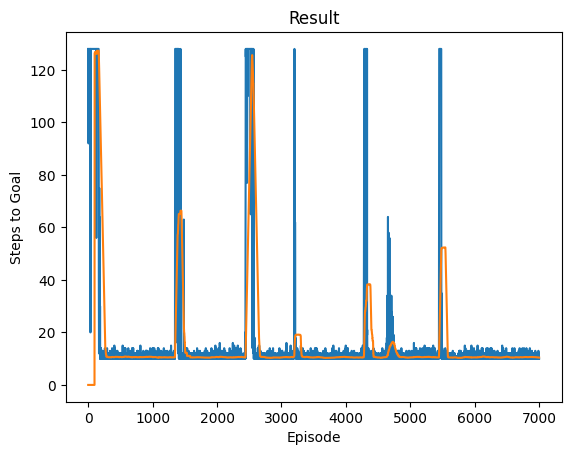

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
num_episodes = 7000
episode_rewards = []
for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = 0
    
    for t in count():
        action = select_action(state)
        observation, reward, done, _ = env.step(action.item())
        episode_reward += reward
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
            
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(episode_reward)
            plot_durations()
            break
            
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [9]:
state = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = policy_net(state).max(1).indices.view(1, 1)
    observation, reward, done, info = env.step(action.item())
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    
    env.render()
    if done:
        break

🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 🤖 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ ⬜️ ⬜️ 🎯 🟦
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦


🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 🤖 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ ⬜️ ⬜️ 🎯 🟦
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦


🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 🤖 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ ⬜️ ⬜️ 🎯 🟦
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦


🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 🤖 ⬜️ ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ ⬜️ ⬜️ 🎯 🟦
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦


🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 🤖 ⬜️ ⬜️ ⬜️ ⬜️ 🎯 🟦
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦


🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ ⬜️ ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🤖 ⬜️ ⬜️ ⬜️ 🎯 🟦
🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦


🟦 🟦 🟦 🟦 🟦 🟦 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ ⬜️ ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦 ⬜️ 🟦 ⬜️ 🟦 ⬜️ 🟦 🟦
🟦